terminal: https://python.land/virtual-environments/virtualenv

yingliu@Yings-Air fraud detection in healthcare % source healthfraud/bin/activate

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from matplotlib.ticker import PercentFormatter, ScalarFormatter
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC  
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import roc_curve, auc , f1_score
from sklearn.metrics import confusion_matrix



#### Read data 

In [8]:
# data train include provider ID and labels
Train = pd.read_csv("data/Train-1542865627584.csv")

# include beneficiary KYC details like health conditions,region
Train_Beneficiarydata = pd.read_csv("data/Train_Beneficiarydata-1542865627584.csv")

# include the claims filed for those patients who are admitted in the hospitals
Train_Inpatientdata=pd.read_csv("data/Train_Inpatientdata-1542865627584.csv")

# include the claims filed for those patients who visit hospitals and not admitted in it.
Train_Outpatientdata=pd.read_csv("data/Train_Outpatientdata-1542865627584.csv")


In [9]:
print("Train\n", Train.shape)
print("Train_Beneficiarydata\n", Train_Beneficiarydata.shape)
print("Train_Inpatientdata\n", Train_Inpatientdata.shape)
print("Train_Outpatientdata\n", Train_Outpatientdata.shape)


Train
 (5410, 2)
Train_Beneficiarydata
 (138556, 25)
Train_Inpatientdata
 (40474, 30)
Train_Outpatientdata
 (517737, 27)


#### Exploratory Data Analysis before Data Preprocessing

##### Inpatient - Procedure Code, Provider, Hospital Stay, Diagnosis Code

In [10]:
# figure out the most common procedure code and diagnosis code for inpatient cases
print('inpatient columns:\n',  Train_Inpatientdata.columns)
Train_Inpatientdata.head(5)

inpatient columns:
 Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'AdmissionDt', 'ClmAdmitDiagnosisCode',
       'DeductibleAmtPaid', 'DischargeDt', 'DiagnosisGroupCode',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5',
       'ClmProcedureCode_6'],
      dtype='object')


,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,...,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,...,NaN,NaN,NaN,NaN,7092.0,NaN,NaN,NaN,NaN,NaN
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,...,25062,40390,4019,NaN,331.0,NaN,NaN,NaN,NaN,NaN
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,...,5119,29620,20300,NaN,3893.0,NaN,NaN,NaN,NaN,NaN


In [11]:
# create a dataframe for concatinating all Procedure Code columns 
inpatient_proc = pd.DataFrame(columns = ['ProcedureCode'])
inpatient_proc['ProcedureCode'] = pd.concat([Train_Inpatientdata["ClmProcedureCode_1"], 
                                           Train_Inpatientdata["ClmProcedureCode_2"],
                                           Train_Inpatientdata["ClmProcedureCode_3"],
                                           Train_Inpatientdata["ClmProcedureCode_4"], 
                                           Train_Inpatientdata["ClmProcedureCode_5"], 
                                           Train_Inpatientdata["ClmProcedureCode_6"]], axis=0, sort=True).dropna()

print(inpatient_proc.shape)
inpatient_proc.head(5)

(29692, 1)


,ProcedureCode
1,7092.0
3,331.0
4,3893.0
5,863.0
6,4576.0


In [12]:
# create a dataframe for provider, hospital stay length
ip_provider = pd.DataFrame(columns = ['Provider', 'Hperiod'])
ip_provider ['Provider'] = Train_Inpatientdata['Provider'].dropna()

startdate = pd.to_datetime(Train_Inpatientdata.AdmissionDt)
enddate = pd.to_datetime(Train_Inpatientdata.DischargeDt)
ip_provider ['Hperiod'] = (enddate - startdate).dt.days + 1

print(ip_provider.shape)
ip_provider.head(5)

(40474, 2)


,Provider,Hperiod
0,PRV55912,7
1,PRV55907,3
2,PRV56046,4
3,PRV52405,9
4,PRV56614,18


In [13]:
# create a dataframe for concatinating all dx Code columns 
inpatient_dx = pd.DataFrame(columns = ['DiagnosisCode'])
inpatient_dx['DiagnosisCode'] = pd.concat([Train_Inpatientdata["ClmDiagnosisCode_1"], 
                                           Train_Inpatientdata["ClmDiagnosisCode_2"],
                                           Train_Inpatientdata["ClmDiagnosisCode_3"],
                                           Train_Inpatientdata["ClmDiagnosisCode_4"], 
                                           Train_Inpatientdata["ClmDiagnosisCode_5"], 
                                           Train_Inpatientdata["ClmDiagnosisCode_6"],
                                           Train_Inpatientdata["ClmDiagnosisCode_7"],
                                           Train_Inpatientdata["ClmDiagnosisCode_8"],
                                           Train_Inpatientdata["ClmDiagnosisCode_9"],
                                           Train_Inpatientdata["ClmDiagnosisCode_10"],], axis=0, sort=True).dropna()

print(inpatient_dx.shape)
inpatient_dx.head(5)

(327328, 1)


,DiagnosisCode
0,1970
1,6186
2,29623
3,43491
4,042


In [14]:
def analyse_cat_columns(dataset,
                        col_to_analyse='' ,
                        prefix = '',title = 'Distribution in percentage ',
                        top_val = 30, 
                        y_lim = np.arange(0,8),
                        color ='blue'):
    """This functiom plot bar graog for categorical column"""
    #get top 30 procedure codes with its count
    val_counts_ = dataset[col_to_analyse].value_counts()
        
    val_counts_df = val_counts_.to_frame() #store this information in dataframe
    val_counts_df[col_to_analyse] = val_counts_df.index
    
    #since simply plotting bar plots for count of each val would not give much information,so it better to plot in percentage.
    val_counts_df[col_to_analyse] = prefix + val_counts_df[col_to_analyse].astype(str)
    val_counts_df['Percentage'] = (val_counts_df['count']/sum(val_counts_df['count']))*100
    
    val_counts_df = val_counts_df.head(top_val)
    
    val_counts_df.plot(x =col_to_analyse, y='Percentage', kind='bar', color = color, \
                        title=title, figsize=(15,5),yticks=y_lim,grid = False )
    
    plt.gca().yaxis.set_major_formatter(PercentFormatter(100))

    plt.show()

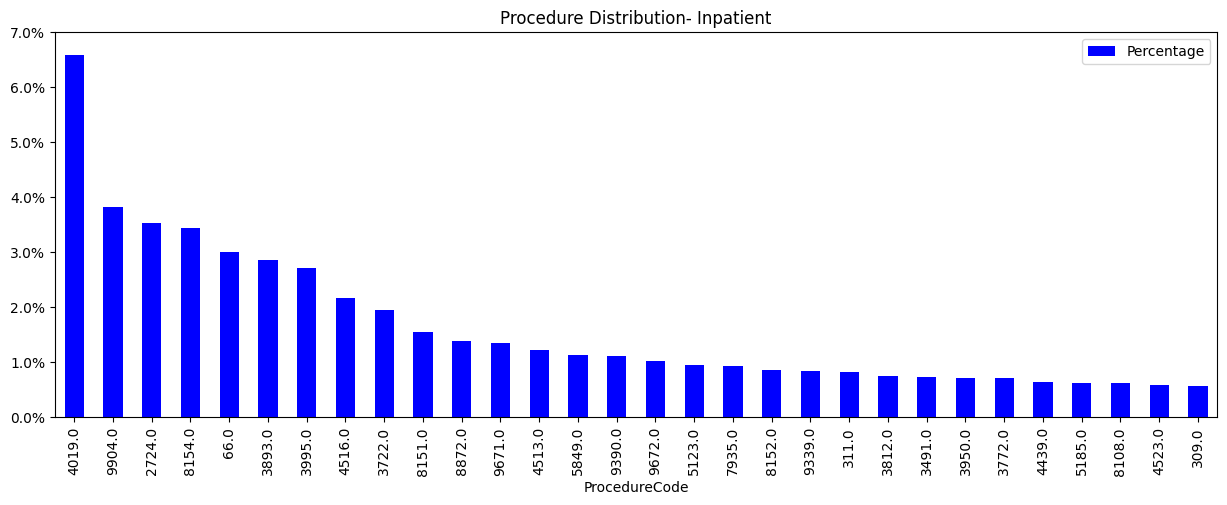

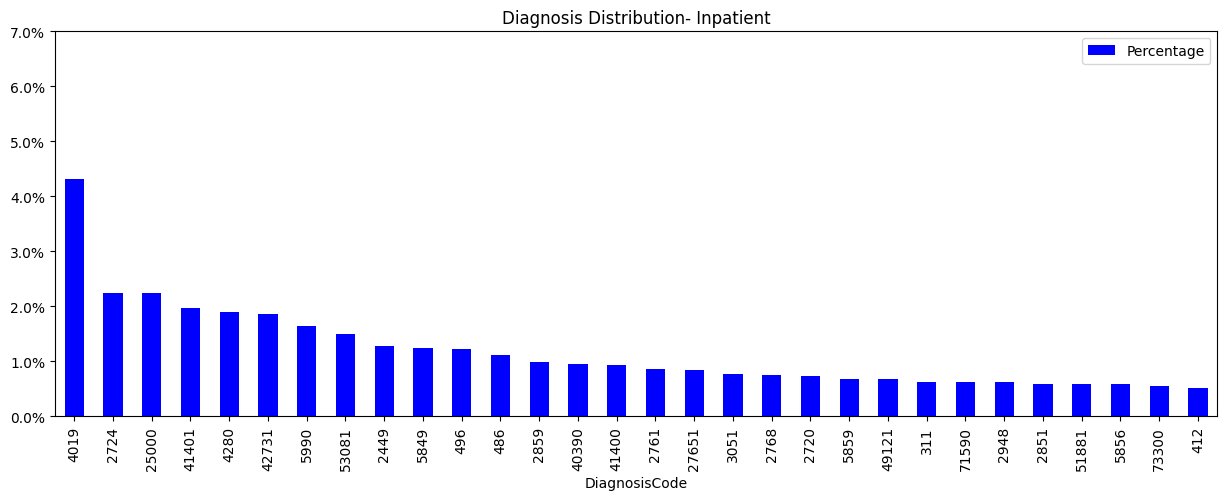

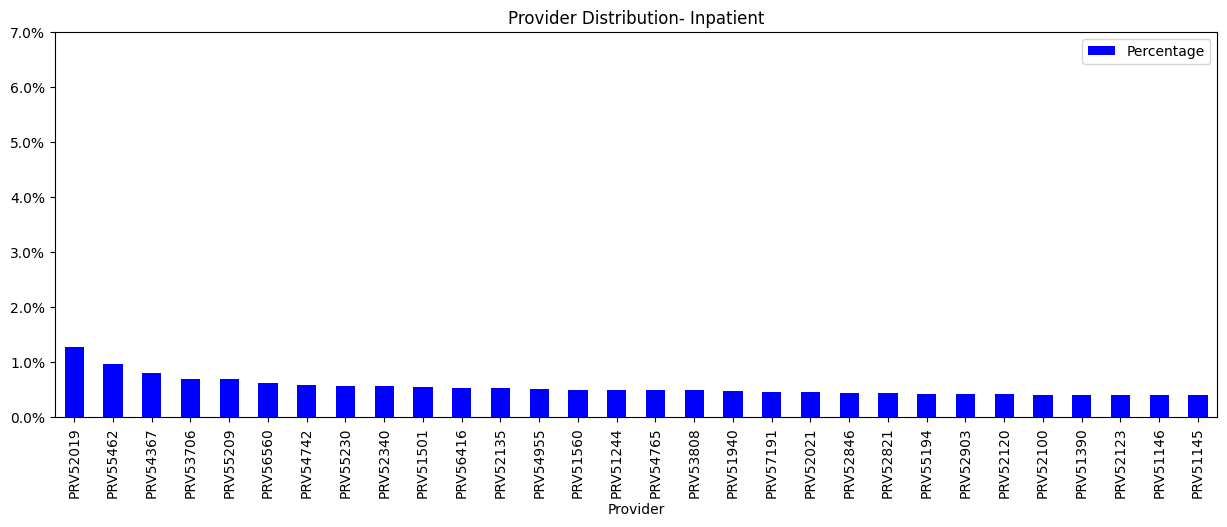

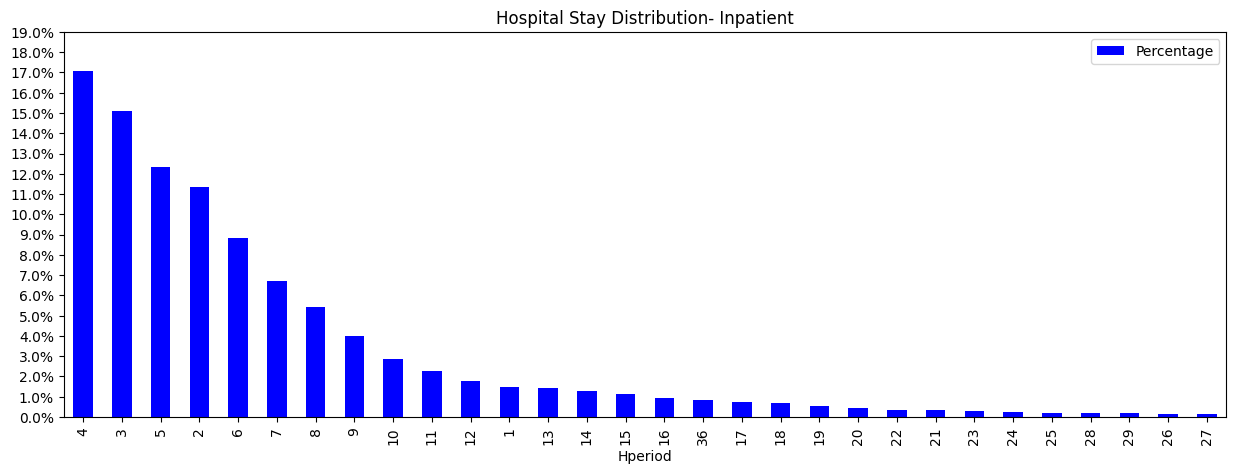

In [15]:
analyse_cat_columns(dataset = inpatient_proc, col_to_analyse='ProcedureCode', title = 'Procedure Distribution- Inpatient')
analyse_cat_columns(dataset = inpatient_dx, col_to_analyse='DiagnosisCode', title = 'Diagnosis Distribution- Inpatient')
analyse_cat_columns(dataset = ip_provider, col_to_analyse='Provider', title = 'Provider Distribution- Inpatient')
analyse_cat_columns(dataset = ip_provider, col_to_analyse='Hperiod', y_lim = np.arange(0,20), title = 'Hospital Stay Distribution- Inpatient')


##### Inpatient - Claim Amount

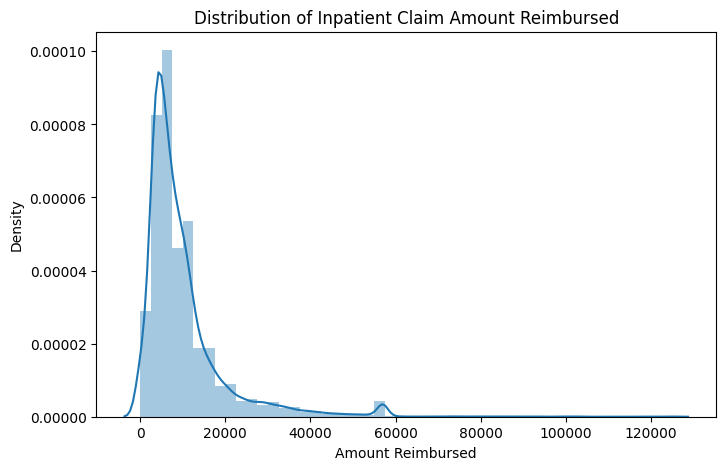

In [25]:
plt.figure(figsize=(8, 5))
sns.distplot(Train_Inpatientdata.InscClaimAmtReimbursed)

# Adding title and labels
plt.title('Distribution of Inpatient Claim Amount Reimbursed')
plt.xlabel('Amount Reimbursed')
plt.ylabel('Density')

# Show plot
plt.show()

##### Conclusions

1. The top procedure is 4019.0. There are 6% patients undergoing this procedure. Based on ICD-9 Code, 4019 is Hypertension NOS (Unspecified essential hypertension).

2. The top diagnosis is also 4019. There are around 4.5% patients diagnosed as Hypertension NOS (Unspecified essential hypertension).

3. In the inpatient claim, providers are evenly distributed. There is no specific providers which submitted more claims than others.

4. More than 90% of paitients stayed in hospital less than 10 days.

5. The distribution of amount reimbursed in the inpatient claim seems like a log normal distribtion. The majority of amount falls between 0 and 20,000.

##### Outpatient - Procedure Code

In [85]:
# figure out the most common procedure code and diagnosis code for outpatient cases
print('outpatient columns:\n',  Train_Outpatientdata.columns)
Train_Outpatientdata.head(5)

outpatient columns:
 Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1',
       'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5', 'ClmProcedureCode_6', 'DeductibleAmtPaid',
       'ClmAdmitDiagnosisCode'],
      dtype='object')


,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,NaN,NaN,78943,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,56409
1,BENE11003,CLM189947,2009-02-12,2009-02-12,PRV57610,80,PHY362868,NaN,NaN,6115,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,79380
2,BENE11003,CLM438021,2009-06-27,2009-06-27,PRV57595,10,PHY328821,NaN,NaN,2723,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
3,BENE11004,CLM121801,2009-01-06,2009-01-06,PRV56011,40,PHY334319,NaN,NaN,71988,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
4,BENE11004,CLM150998,2009-01-22,2009-01-22,PRV56011,200,PHY403831,NaN,NaN,82382,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,71947


In [86]:
# create a dataframe for concatinating all Procedure Code columns 
outpatient_proc = pd.DataFrame(columns = ['ProcedureCode'])
outpatient_proc['ProcedureCode'] = pd.concat([Train_Outpatientdata["ClmProcedureCode_1"], 
                                           Train_Outpatientdata["ClmProcedureCode_2"],
                                           Train_Outpatientdata["ClmProcedureCode_3"],
                                           Train_Outpatientdata["ClmProcedureCode_4"], 
                                           Train_Outpatientdata["ClmProcedureCode_5"], 
                                           Train_Outpatientdata["ClmProcedureCode_6"]], axis=0, sort=True).dropna()

print(outpatient_proc.shape)
outpatient_proc.head(5)

(204, 1)


,ProcedureCode
8167,9672.0
9326,4573.0
14740,66.0
30435,66.0
35839,5123.0


In [ ]:
# create a dataframe for concatinating all dx Code columns 
outpatient_dx = pd.DataFrame(columns = ['DiagnosisCode'])
outpatient_dx['DiagnosisCode'] = pd.concat([Train_Outpatientdata["ClmDiagnosisCode_1"], 
                                           Train_Outpatientdata["ClmDiagnosisCode_2"],
                                           Train_Outpatientdata["ClmDiagnosisCode_3"],
                                           Train_Outpatientdata["ClmDiagnosisCode_4"], 
                                           Train_Outpatientdata["ClmDiagnosisCode_5"], 
                                           Train_Outpatientdata["ClmDiagnosisCode_6"],
                                           Train_Outpatientdata["ClmDiagnosisCode_7"],
                                           Train_Outpatientdata["ClmDiagnosisCode_8"],
                                           Train_Outpatientdata["ClmDiagnosisCode_9"],
                                           Train_Outpatientdata["ClmDiagnosisCode_10"],], axis=0, sort=True).dropna()

print(outpatient_dx.shape)
outpatient_dx.head(5)

In [118]:
# create a dataframe for provider, claim length
op_provider = pd.DataFrame(columns = ['Provider', 'Cperiod'])
op_provider ['Provider'] = Train_Outpatientdata['Provider'].dropna()

startdate = pd.to_datetime(Train_Outpatientdata.ClaimStartDt)
enddate = pd.to_datetime(Train_Outpatientdata.ClaimEndDt)
op_provider ['Cperiod'] = (enddate - startdate).dt.days + 1

print(op_provider.shape)
op_provider.head(5)

(517737, 2)


,Provider,Cperiod
0,PRV56011,1
1,PRV57610,1
2,PRV57595,1
3,PRV56011,1
4,PRV56011,1


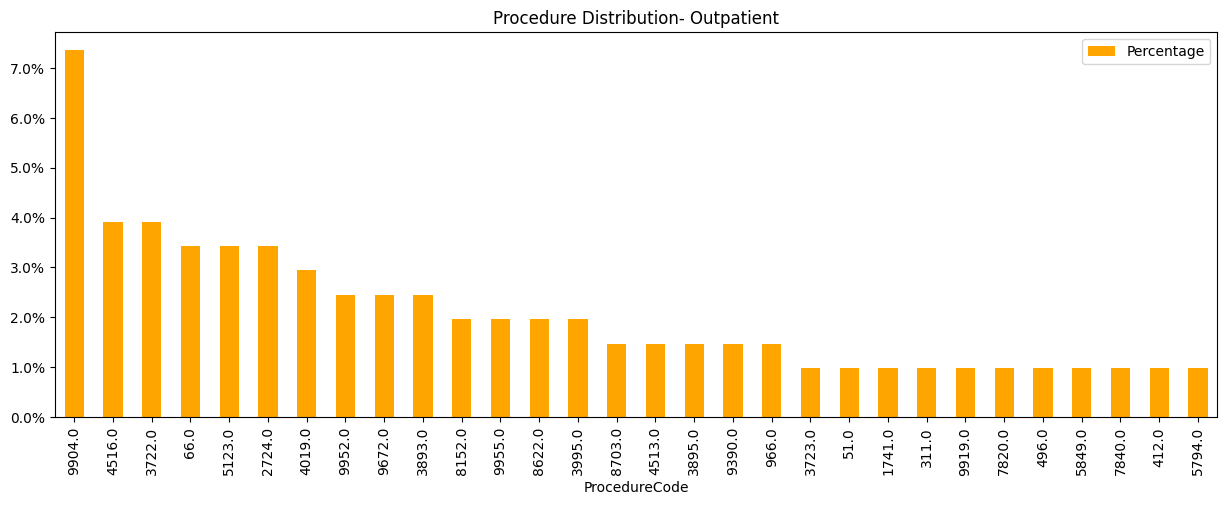

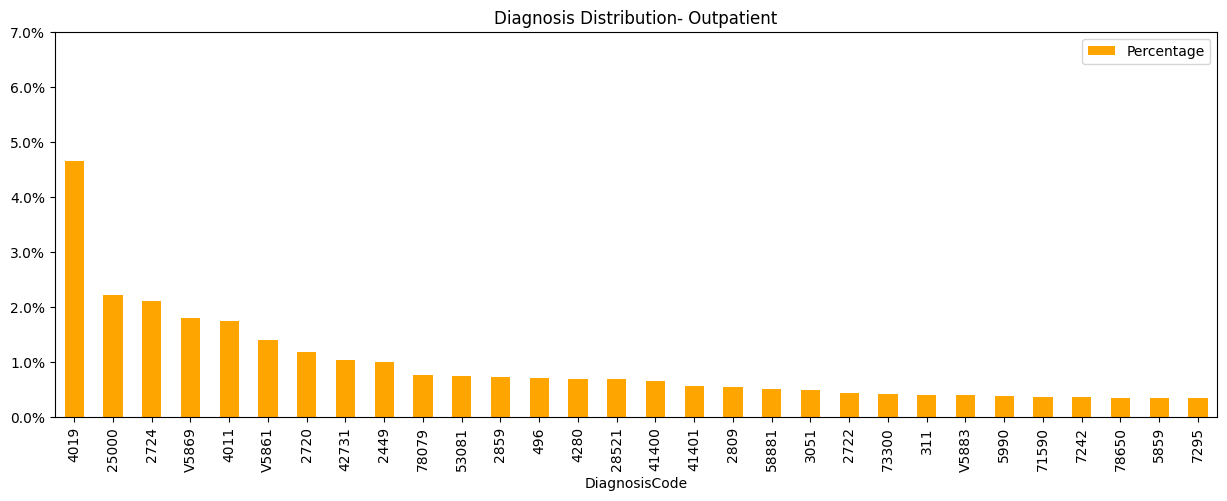

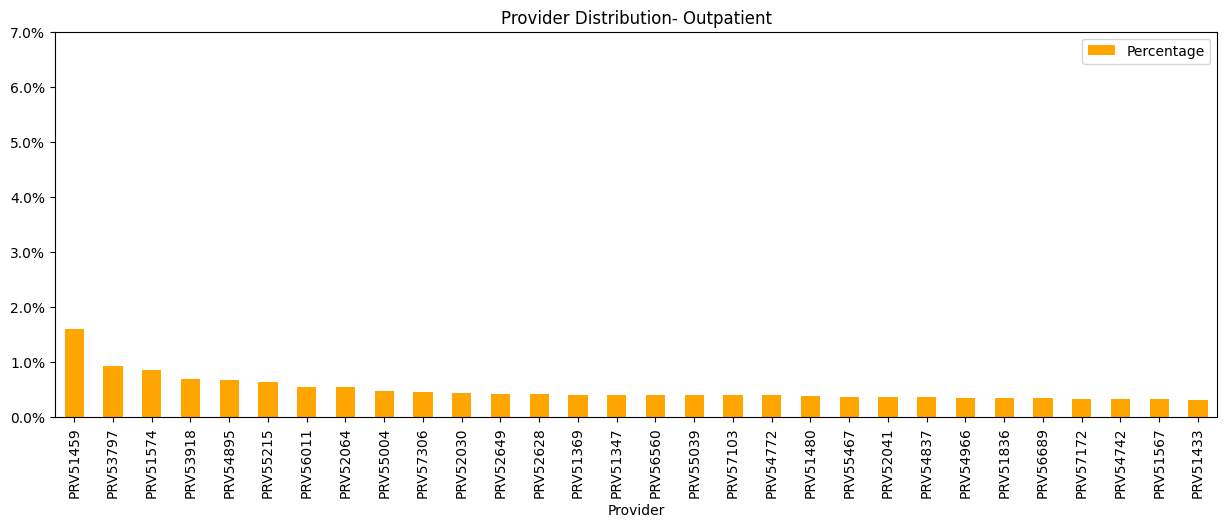

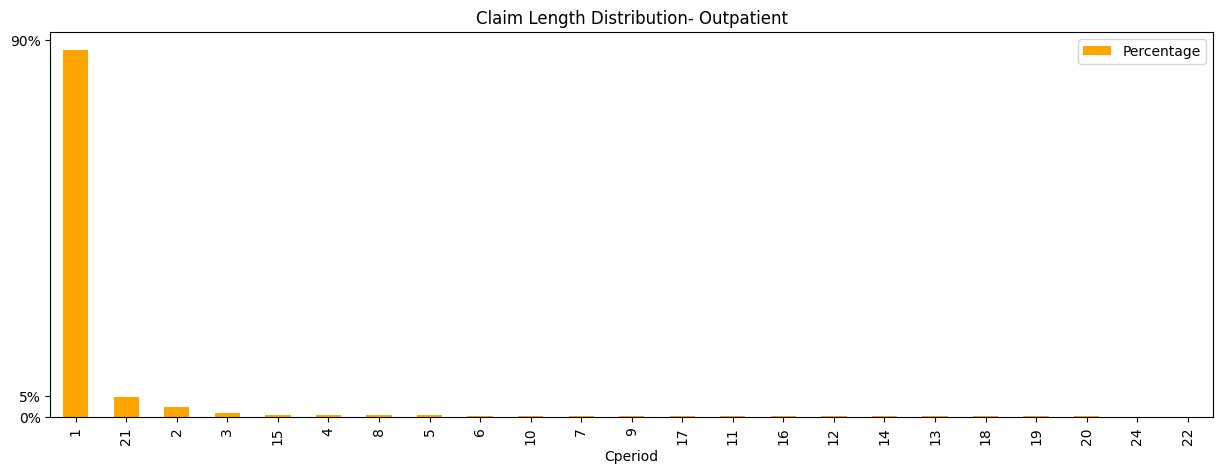

In [128]:
analyse_cat_columns(dataset = outpatient_proc, col_to_analyse='ProcedureCode', title = 'Procedure Distribution- Outpatient', color ='orange')
analyse_cat_columns(dataset = outpatient_dx, col_to_analyse='DiagnosisCode', title = 'Diagnosis Distribution- Outpatient', color ='orange')
analyse_cat_columns(dataset = op_provider, col_to_analyse='Provider', title = 'Provider Distribution- Outpatient', color ='orange')
analyse_cat_columns(dataset = op_provider, col_to_analyse='Cperiod', y_lim = (0,90,5), title = 'Claim Length Distribution- Outpatient', color ='orange')


##### Outpatient - Claim Amount

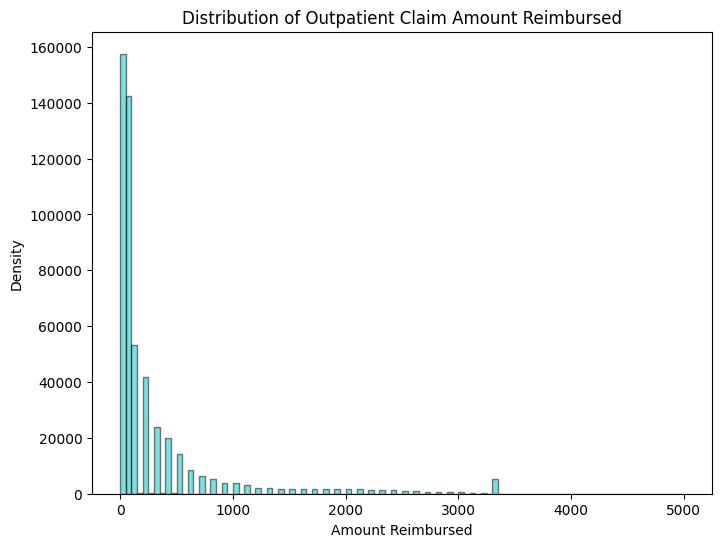

In [29]:
plt.figure(figsize=(8, 5))

Train_Outpatientdata['InscClaimAmtReimbursed'].plot.hist(bins=100,range=[0,5000], alpha=0.5, figsize=(8, 6), facecolor='c', edgecolor='k')

# Adding title and labels
plt.title('Distribution of Outpatient Claim Amount Reimbursed')
plt.xlabel('Amount Reimbursed')
plt.ylabel('Density')

# Show plot
plt.show()

In [30]:
val = np.percentile(Train_Outpatientdata.InscClaimAmtReimbursed,99.9)
val

3500.0

##### Conclusions

The top procedure is 9904.0. There are around 7.3% patients undergoing this procedure. Based on ICD-9 Code, 9904 is Transfusion Of Packed Cells. 4516 is the second popular procedure, which is Esophagogastroduodenoscopy [Egd] With Closed Biopsy.

The top diagnosis is the same as the inpatient's data -  4019. There are around 4.5% patients diagnosed as Hypertension NOS (Unspecified essential hypertension). The second dx code 25000 is Incision Procedures on the Forearm and Wrist.

Provider 'PRV51459' has around 1% more claims than other providers.

The majority of claim length is 1 day.

The claim reimbursed amount in outpaitent claims shows a rough log normal distribution. However, on the tail, there is a signal of outliers around $3500.

#### Merging OutPatient ,Inpatient and Beneficiary to get the whole dataset


In [5]:
Train_Allpatientdata = pd.merge(Train_Outpatientdata, Train_Inpatientdata, how='outer')
Train_Allpatientdata = pd.merge(Train_Allpatientdata, Train_Beneficiarydata, on = 'BeneID', how = 'inner')

#### Data preprocessing

In [6]:
# add labels
df = pd.merge(Train_Allpatientdata, Train, on = 'Provider')
df

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,PotentialFraud
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,NaN,NaN,78943,...,2,2,2,2,2,0,0,30,50,Yes
1,BENE11004,CLM121801,2009-01-06,2009-01-06,PRV56011,40,PHY334319,NaN,NaN,71988,...,1,1,1,1,2,0,0,1810,760,Yes
2,BENE11004,CLM150998,2009-01-22,2009-01-22,PRV56011,200,PHY403831,NaN,NaN,82382,...,1,1,1,1,2,0,0,1810,760,Yes
3,BENE11004,CLM173224,2009-02-03,2009-02-03,PRV56011,20,PHY339887,NaN,NaN,20381,...,1,1,1,1,2,0,0,1810,760,Yes
4,BENE11004,CLM224741,2009-03-03,2009-03-03,PRV56011,40,PHY345721,NaN,NaN,V6546,...,1,1,1,1,2,0,0,1810,760,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558206,BENE57978,CLM37910,2009-02-11,2009-02-16,PRV53511,0,PHY378514,PHY426843,NaN,40491,...,1,1,2,1,2,2200,2136,30,100,No
558207,BENE80245,CLM79653,2009-12-15,2009-12-18,PRV51711,4000,PHY345109,NaN,NaN,2948,...,1,2,2,2,2,4000,1068,0,0,No
558208,BENE85177,CLM77745,2009-11-29,2009-12-07,PRV54503,8000,PHY418343,NaN,NaN,515,...,2,1,2,2,2,8000,1068,0,0,No
558209,BENE105577,CLM53155,2009-05-28,2009-05-31,PRV51239,5000,PHY382916,NaN,NaN,27651,...,1,1,2,2,2,5000,1068,0,0,No


In [7]:
# Drop irrelevant columns
df = df.drop(['BeneID', 'ClaimID'], axis = 1)

In [8]:
#show null values amount
print('null value amount:\n', df.isna().sum())

#show null values percentage
print('null value percentage:\n', df.isnull().mean()*100)

#figure out high percentage columns
nullPercent = df.isnull().mean()*100
filtered_columns = nullPercent[nullPercent > 70].index
print(filtered_columns)



null value amount:
 ClaimStartDt                            0
ClaimEndDt                              0
Provider                                0
InscClaimAmtReimbursed                  0
AttendingPhysician                   1508
OperatingPhysician                 443764
OtherPhysician                     358475
ClmDiagnosisCode_1                  10453
ClmDiagnosisCode_2                 195606
ClmDiagnosisCode_3                 315156
ClmDiagnosisCode_4                 393675
ClmDiagnosisCode_5                 446287
ClmDiagnosisCode_6                 473819
ClmDiagnosisCode_7                 492034
ClmDiagnosisCode_8                 504767
ClmDiagnosisCode_9                 516396
ClmDiagnosisCode_10                553201
ClmProcedureCode_1                 534901
ClmProcedureCode_2                 552721
ClmProcedureCode_3                 557242
ClmProcedureCode_4                 558093
ClmProcedureCode_5                 558202
ClmProcedureCode_6                 558211
DeductibleAmtP

In [10]:
# deal with dx code and proc code
# Applying coalesce function to dx columns 
# filling dx_1 by other dx columns  
df['ClmDiagnosisCode_1'] = df[[f'ClmDiagnosisCode_{i}' for i in range(1, 11)]].fillna(method='ffill', axis=1)['ClmDiagnosisCode_1']
df['ClmDiagnosisCode_2'] = df[[f'ClmDiagnosisCode_{i}' for i in range(2, 11)]].fillna(method='ffill', axis=1)['ClmDiagnosisCode_2']
df['ClmDiagnosisCode_3'] = df[[f'ClmDiagnosisCode_{i}' for i in range(3, 11)]].fillna(method='ffill', axis=1)['ClmDiagnosisCode_3']


# Applying coalesce function to proc columns 
df['ClmProcedureCode_1'] = df[[f'ClmProcedureCode_{i}' for i in range(1, 7)]].fillna(method='ffill', axis=1)['ClmProcedureCode_1']
df['ClmProcedureCode_2'] = df[[f'ClmProcedureCode_{i}' for i in range(2, 7)]].fillna(method='ffill', axis=1)['ClmProcedureCode_2']



In [11]:
#show null values amount
print('null value amount:\n', df.isna().sum())

#show null values percentage
print('null value percentage:\n', df.isnull().mean()*100)

#figure out high percentage columns
nullPercent = df.isnull().mean()*100
filtered_columns = nullPercent[nullPercent > 70].index
print(filtered_columns)

null value amount:
 ClaimStartDt                            0
ClaimEndDt                              0
Provider                                0
InscClaimAmtReimbursed                  0
AttendingPhysician                   1508
OperatingPhysician                 443764
OtherPhysician                     358475
ClmDiagnosisCode_1                  10453
ClmDiagnosisCode_2                 195606
ClmDiagnosisCode_3                 315156
ClmDiagnosisCode_4                 393675
ClmDiagnosisCode_5                 446287
ClmDiagnosisCode_6                 473819
ClmDiagnosisCode_7                 492034
ClmDiagnosisCode_8                 504767
ClmDiagnosisCode_9                 516396
ClmDiagnosisCode_10                553201
ClmProcedureCode_1                 534901
ClmProcedureCode_2                 552721
ClmProcedureCode_3                 557242
ClmProcedureCode_4                 558093
ClmProcedureCode_5                 558202
ClmProcedureCode_6                 558211
DeductibleAmtP

In [12]:
# three methods to deal with dx columns and proc columns
# method 1: drop columns where null values percentage > 70%
# remove columns which null value percentage is larger than 70% after processing
df = df.drop(['ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1',
       'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5', 'ClmProcedureCode_6'], axis = 1)

In [ ]:
# method 2: concatenate all the dx code and apply one-hot encoding (don't consider the seq)



In [ ]:
# method 3: concatenate all the dx code and apply one-hot encoding (consider the seq)



In [13]:
# calculate the number of inpatient days
startdate = pd.to_datetime(df.AdmissionDt)
enddate = pd.to_datetime(df.DischargeDt)
df['Hperiod'] = (enddate - startdate).dt.days

In [14]:
# calculate the period of claim
startdate = pd.to_datetime(df.ClaimStartDt)
enddate = pd.to_datetime(df.ClaimEndDt)
df['Cperiod'] = (enddate - startdate).dt.days

check for same physician in all three physician columns

In [15]:
def physician_same(row):
    atten_oper = row['AttendingPhysician'] == row['OperatingPhysician']
    oper_other = row['OperatingPhysician'] == row['OtherPhysician']
    atten_other = row['AttendingPhysician'] == row['OtherPhysician']
    
    # atten = oper = other
    if atten_oper == True and oper_other == True:
        return 0
    
    # atten = oper != other
    elif atten_oper == True and oper_other == False:
        return 1
    
    # atten = other != oper
    elif atten_other == True and oper_other == False:
        return 2
    
    # atten != other = oper
    elif atten_other == False and oper_other == True:
        return 3
    
    # atten != other != oper
    else:
        return 4


df['phy_same'] = df.apply(physician_same, axis=1)

encode label and check whether the data is balanced

['No', 'Yes']


array([1, 0])

In [22]:
# check whether the data is balanced
# 38% positive cases
df['PotentialFraud'].unique()
(df['PotentialFraud'] == "Yes").sum() /len(df)




0.3812106891480103

one hot encoding for the categorical features

In [56]:
from sklearn.preprocessing import OneHotEncoder     # One Hot Encoding 

encoder = OneHotEncoder()
one_hot = encoder.fit_transform(df[['Gender']]).toarray()

# df = pd.concat([df, pd.DataFrame(one_hot, columns=encoder.get_feature_names())], axis=1)


# print(df)